In [1]:
!pip install pennylane

In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools


[39, 55, 21, 12, 82, 63, 5, 87, 10, 65]
[1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]


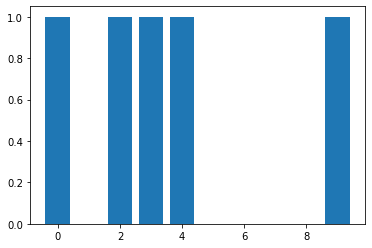

In [3]:

# use some python libaries to solve this problem in a conventional computing method:
def conventional_search(count1, values_arr):
    total = np.sum(values_arr)
    sz = len(values_arr)
    
    for ele in itertools.combinations(values_arr,sz//2):
        count1+=1
        if sum(ele)==total//2:
            #print("Took "+str(count1)+" Iterations")
            return ele, count1
    return np.zeros(sz//2),-1
        
def convert_res(count1, size):
    
    np_values_arr = np.random.randint(1,101,size)
    values_arr = np_values_arr.tolist()
    print(values_arr)

    results_arr = np.zeros(len(values_arr))
    if conventional_search(count1, values_arr)[1]>-1:
        for ele in conventional_search(count1, values_arr)[0]:
            results_arr[values_arr.index(ele)]=1
        return results_arr

count1=0
size = 10
values = convert_res(count1,size)
plt.bar(range(len(values)), values)
print(values)


[11, 21, 70, 83, 66, 54, 76, 2, 55, 31]
[1. 0. 0. 1. 0. 1. 0. 0. 1. 1.]


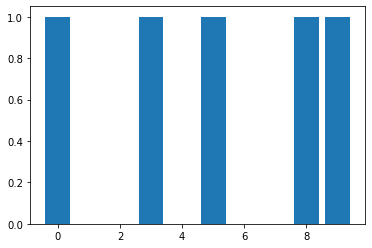

In [24]:
count1=0
size = 10
values = convert_res(count1,size)
plt.bar(range(len(values)), values)
print(values)

In [14]:
# test the average number of iterations
def find_average(n):
    avg_arr = []
    count = 0
    while count < n:
        size = 10
        np_property_prices = np.random.randint(1,101,size)
        property_prices = np_property_prices.tolist()
        
        if conventional_search(count1,property_prices)[1] >-1:
            avg_arr.append(conventional_search(count1,property_prices)[1])
            #print(conventional_search(count1,property_prices))
            count+=1
        
    return np.average(avg_arr)

find_average(10000)

69.8269

we can see an average about 70 iteration for an array of size 10. Note that this is also for a randomly generated array from with values 1 to 100. We can call this our N, representing the amount of iterations needed on average for a linear searching algorithm.

[51, 54, 14, 17, 26, 4, 34, 18, 61, 42]
[0 1 0 0 1 1 0 0 0 1]


<BarContainer object of 10 artists>

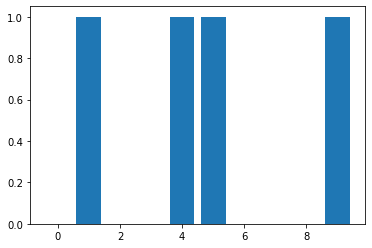

In [15]:
size = 10
np_values_arr = np.random.randint(1,101,size)
values_arr = np_values_arr.tolist()
count=0
wires_set = list(range(len(values_arr)))
aux_wires = list(range(len(values_arr),2*len(values_arr)))

# this is the function for the oracle operator
# it will flip the sign of the operator that meets the conditions
def oracle(wires_set, aux_oracle_wires):
    
    # function for the quantum Fourier transform
    def fourier_K(k, wires):
        for j in range(len(wires)):
            # use the RZ gets on all wires with a value of k*pi/2^j
            qml.RZ(k * np.pi / (2**j), wires=wires[j])
        
    # function that applies the Quantum Fourier transform to the second set of wires
    def aux_function():
        qml.QFT(wires = aux_oracle_wires)
        # loop through the wires
        for wire in wires_set:
            # create a controlled version of the circuit provided
            qml.ctrl(fourier_K, control = wire)(values_arr[wire], wires = aux_oracle_wires)
            
        qml.adjoint(qml.QFT)(wires = aux_oracle_wires) # apply the adjoint operator the aux wires
        
    aux_function() # call function
    qml.FlipSign(sum(values_arr) // 2, wires = aux_oracle_wires) # this is where we define the solution to flip

    qml.adjoint(aux_function)() # apply the adjoint on the aux circuit

# define the q circuit device
dev = qml.device('default.qubit', wires = wires_set +aux_wires, shots = 1)

# function that implements grover's algorithm on a Quantum circuit
@qml.qnode(dev)
def circuit():
    # apply the Hadamard to the circuit
    for wire in wires_set:
        qml.Hadamard(wires = wire)
       
    # call the custom oracle function
    oracle(wires_set, aux_wires)
    
    # apply the grover operator on the wires
    qml.GroverOperator(wires = wires_set)
    
    # return the positive states in the circuit
    return qml.sample(wires = wires_set)


values = circuit()
print(values_arr)
print(values)
plt.bar(range(len(values)), values)

In [20]:
def test_Grovers(size,count):
    np_values_arr = np.random.randint(1,101,size)
    values_arr = np_values_arr.tolist()

    wires_set = list(range(len(values_arr)))
    aux_wires = list(range(len(values_arr),2*len(values_arr)))

    # this is the function for the oracle operator
    # it will flip the sign of the operator that meets the conditions
    def oracle(wires_set, aux_oracle_wires, count):

        # function for the quantum Fourier transform
        def fourier_K(count, k, wires):
            for j in range(len(wires)):
                # use the RZ gets on all wires with a value of k*pi/2^j
                qml.RZ(k * np.pi / (2**j), wires=wires[j])
                count+=1
            
            
        # function that applies the Quantum Fourier transform to the second set of wires
        def aux_function(count):
            qml.QFT(wires = aux_oracle_wires)
            # loop through the wires
            for wire in wires_set:
                # create a controlled version of the circuit provided
                qml.ctrl(fourier_K, control = wire)(count,values_arr[wire], wires = aux_oracle_wires)
                count+=1
            print(count)
            qml.adjoint(qml.QFT)(wires = aux_oracle_wires) # apply the adjoint operator the aux wires

        aux_function(count) # call function
        qml.FlipSign(sum(values_arr) // 2, wires = aux_oracle_wires) # this is where we define the solution to flip

        qml.adjoint(aux_function)(count) # apply the adjoint on the aux circuit

    # define the q circuit device
    dev = qml.device('default.qubit', wires = wires_set +aux_wires, shots = 1) # note that shots =1 allows parsing of flipped states

    # function that implements grover's algorithm on a Quantum circuit
    @qml.qnode(dev)
    def circuit():
        # apply the Hadamard to the circuit
        for wire in wires_set:
            qml.Hadamard(wires = wire)

        # call the custom oracle function
        oracle(wires_set, aux_wires,count)

        # apply the grover operator on the wires
        qml.GroverOperator(wires = wires_set)

        # return the positive states in the circuit
        return qml.sample(wires = wires_set)



    values = circuit()
    print(values_arr)
    print(values)
    #plt.bar(range(len(values)), values)
    #print(count)



for _ in range(5):
    test_Grovers(10,0)


10
10
[88, 88, 25, 19, 96, 77, 70, 85, 60, 39]
[0 0 0 0 1 1 1 0 1 1]
10
10
[62, 66, 39, 86, 13, 97, 51, 13, 75, 64]
[1 0 1 1 0 1 0 1 0 0]
10
10
[19, 3, 83, 9, 57, 28, 21, 10, 58, 74]
[1 0 1 1 0 1 1 1 1 1]
10
10
[85, 29, 45, 46, 35, 75, 2, 82, 67, 72]
[0 1 1 1 0 0 1 0 0 1]
10
10
[55, 44, 92, 13, 45, 36, 78, 98, 27, 99]
[1 0 0 1 0 0 0 0 0 1]


We can see that regardless of the values in the array sent to the quantum algorithm for an array of size 10 the circuit will take 10 *2 iterations or 20 iterations to return the desired states. This is exactly what was expected. The Linear search on average needed about 70 iteration, which was based on the combinations of the array.